In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import torch
from torch import nn

from src.plot_utils import plot_feature, plot_groupby, crossplot_pred
from src.train_utils import create_dataloader, train, predict
from src.losses import AsymmetricMSELoss, AsymmetricBCELoss
from src.models import TimeSeriesTransformer

In [2]:
%load_ext autoreload
%autoreload 2

### Main blocks

[Constants](#Constants)<br>
[Exploratory data analysis](#Exploratory-data-analysis)<br>
[Problem statement](#Problem-statement)<br>
[Data preprocessing](#Data-preprocessing)<br>
[Baseline Model](#Baseline-model)<br>
[Transformers](#Transformers)<br>
[Сonclusions](#Conclusions)<br>

## Constants

In [3]:
TRAIN_SPLIT_SIZE = .8
SEED = 42

# transformers
BATCH_SIZE = 256
LR = 0.01
WEIGHT_DECAY = 0.01
N_EPOCHS = 60
WINDOW_SIZE = 30

## Exploratory data analysis

In [4]:
data_path = './data/data.csv'

In [5]:
df = pd.read_csv(data_path)

In [6]:
df.head(10)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
5,1,6,518.67,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,...,23.3669,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,-0.0043,-0.0001
6,1,7,518.67,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,...,23.3774,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,0.0010,0.0001
7,1,8,518.67,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,...,23.3106,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,-0.0034,0.0003
8,1,9,518.67,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,...,23.4066,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,0.0008,0.0001
9,1,10,518.67,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,...,23.4694,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,-0.0033,0.0001


In [7]:
df.tail(10)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
16128,80,176,518.67,1.3,47.92,521.08,2388.20,8204.48,8.5111,0.03,...,23.1720,1600.14,1428.42,14.62,21.61,552.11,2388.12,9139.28,0.0014,0.0001
16129,80,177,518.67,1.3,48.07,520.15,2388.11,8206.52,8.4967,0.03,...,23.0713,1603.93,1423.61,14.62,21.61,551.94,2388.17,9143.78,-0.0004,0.0004
16130,80,178,518.67,1.3,48.12,520.80,2388.18,8216.30,8.5173,0.03,...,23.1038,1603.07,1420.15,14.62,21.61,551.81,2388.09,9149.03,0.0000,0.0000
16131,80,179,518.67,1.3,48.06,520.50,2388.10,8211.19,8.4860,0.03,...,23.1907,1613.29,1432.42,14.62,21.61,551.59,2388.15,9144.00,-0.0006,-0.0003
16132,80,180,518.67,1.3,48.03,520.01,2388.12,8215.84,8.5194,0.03,...,23.0692,1602.87,1422.70,14.62,21.61,551.54,2388.17,9155.94,0.0005,-0.0002
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,...,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,...,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,...,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,...,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002
16137,80,185,518.67,1.3,48.05,520.00,2388.18,8229.73,8.5250,0.03,...,23.0323,1606.38,1421.41,14.62,21.61,551.55,2388.22,9170.57,0.0015,0.0000


In [8]:
# Let's look unique id of timeseries in dataset
df.id.unique().shape 

(80,)

Try to find constant features. Each p-th and s-th element of dataset is float number. I don't want to use `unique` function for floats so we could calculate std to find a zero.

In [9]:
df.std()

id       2.339535e+01
cycle    6.591530e+01
p00      0.000000e+00
p01      2.220515e-16
p02      2.674218e-01
p03      7.382523e-01
p04      7.260372e-02
p05      1.973135e+01
p06      3.751962e-02
p07      1.387822e-17
p08      1.549031e+00
p09      0.000000e+00
p10      0.000000e+00
p11      5.007111e-01
p12      1.810428e-01
p13      1.086055e-01
p14      6.129960e+00
p15      8.977073e+00
p16      3.552824e-15
p17      1.417433e-03
p18      8.879473e-01
p19      7.160782e-02
p20      2.278136e+01
s1       2.188188e-03
s2       2.939096e-04
dtype: float64

`p00`, `p09`, `p10` are constant values and could be removed from dataset without loss of information. <br>
`p01`, `p07`, `p16` have a std is very close to zero, so it looks like a contant values. A non-zero value of std is an error of float calculation.

Text(0.5, 1.0, 'Max cycle of timeseries. min: 128, max: 362')

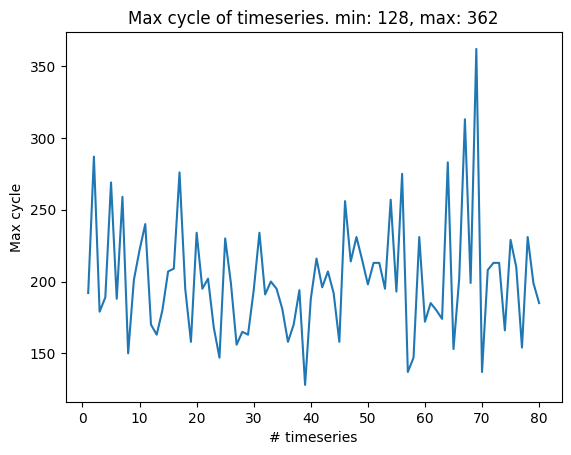

In [10]:
cycle_max = df.groupby(by='id')['cycle'].max()
plt.plot(cycle_max)
plt.xlabel('# timeseries')
plt.ylabel('Max cycle')
plt.title(f'Max cycle of timeseries. min: {cycle_max.min()}, max: {cycle_max.max()}')

Split the dataset by timeseries and look for statistsics by each timeseries.

There are a lot of numbers. Let's visualize it.

In [11]:
df_drop = df.drop(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], axis=1)

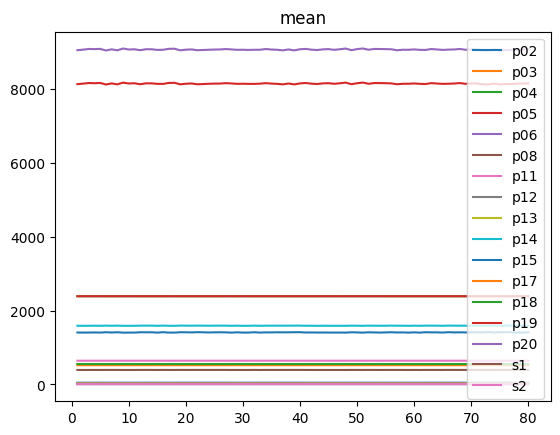

In [12]:
plot_groupby(df_drop, 'mean', show_labels=True)

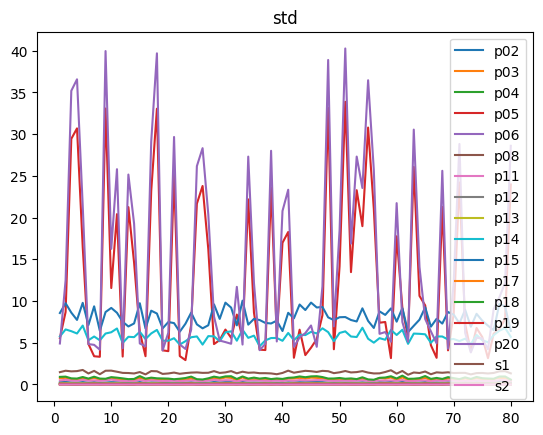

In [13]:
plot_groupby(df_drop, 'std', show_labels=True)

Text(0.5, 1.0, 'p20 range of timeseries. min: 19.140, max: 188.170')

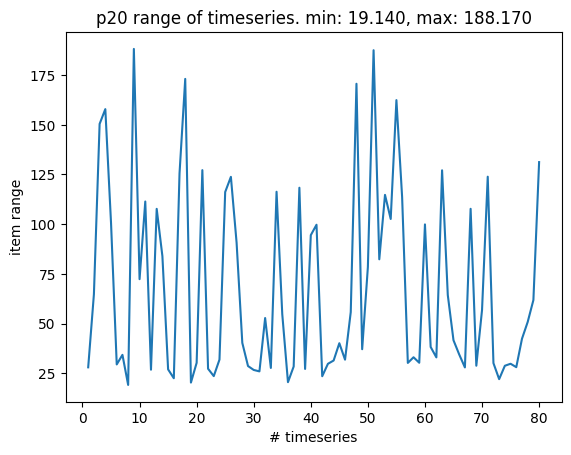

In [14]:
item = 'p20'
item_range = df.groupby(by='id')[item].max() - df.groupby(by='id')[item].min()
plt.plot(item_range)
plt.xlabel('# timeseries')
plt.ylabel('item range')
plt.title(f'{item} range of timeseries. min: {item_range.min():.3f}, max: {item_range.max():.3f}')

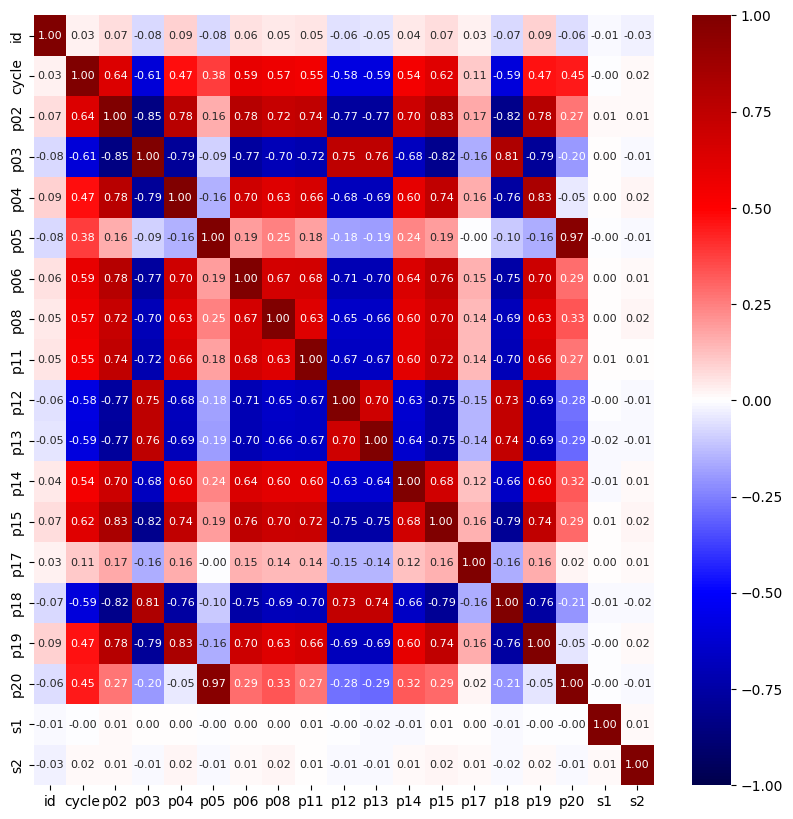

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(df_drop.corr(), ax=ax, cmap='seismic', vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 8}, fmt=".2f")

### Plot some features

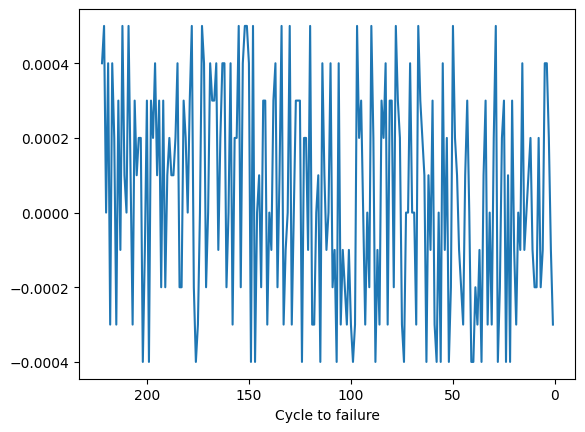

In [16]:
plot_feature(df, 's2', timeseries=[10])

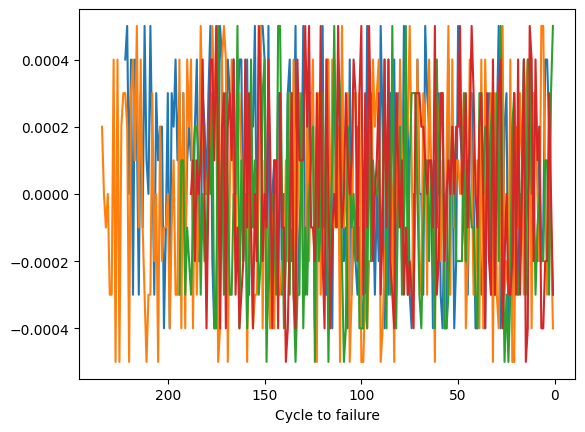

In [17]:
plot_feature(df, 's2', timeseries=[10, 20, 30, 40])

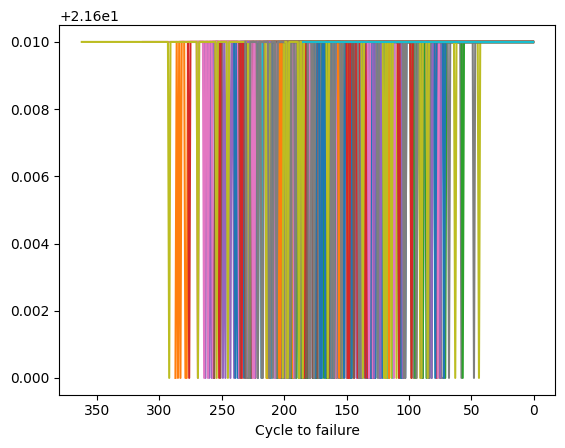

In [18]:
plot_feature(df, 'p17')

In [19]:
df.p17.unique()

array([21.61, 21.6 ])

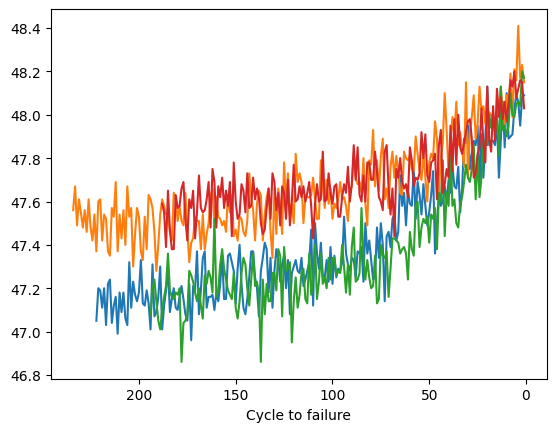

In [20]:
plot_feature(df, 'p02', timeseries=[10, 20, 30, 40])

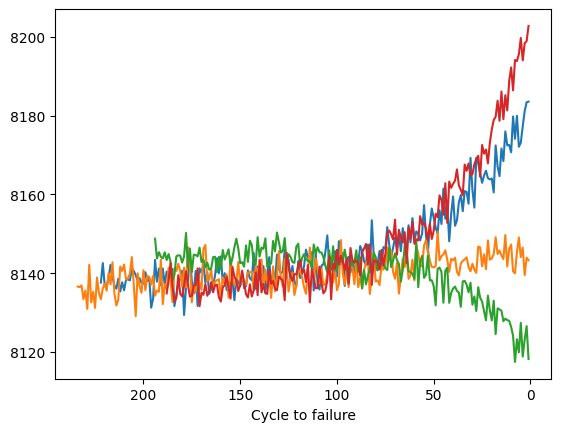

In [21]:
plot_feature(df, 'p05', timeseries=[10, 20, 30, 40])

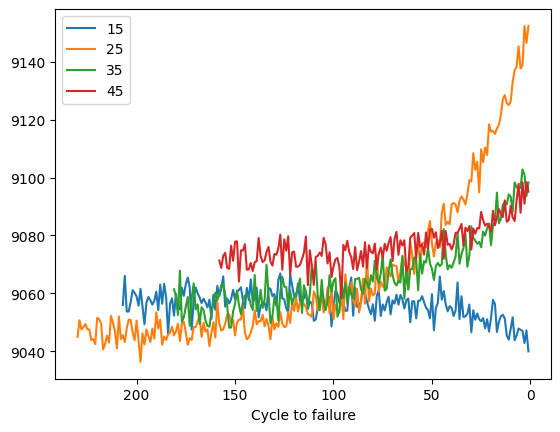

In [22]:
plot_feature(df, 'p20', timeseries=[15, 25, 35, 45], show_legend=True)

### EDA conclusions: 

- `p00`, `p01`, `p07`, `p09`, `p10`, `p16` are the constant values and should be removed.
- data scaling by each features are nessesary and should be standard.
- data of the different timeseries are consistent and could be same preprocessing.
- train-test split must be by timeseries and may be random.
- features are high-correlated. <b>features are not distributed independently</b>.
- bayesian method shouldn't work with this data. Other ML method may have some problems.
- `p05` and `p20` has a different distribution of values by timeseries.  I'd like to remove it both.
- `p17` looks like a binary feature.

## Problem statement

The business wants to predict the failure cycle in order to avoid failure. For example, to repair the engine before failure.<br>
Business Hypothesis: Client will be happy if they know about the next failure within the next 30 cycles.<br>
Let's formulate the ML problems in two way:
- regression problem to predict cycle before failure (TTF problem)
- classification problem to predict if failure will occur in next 30 cycles

Add labels for each problem to dataset

In [23]:
# add regression label
timeseries_lenght = [df[df['id'] == i]['cycle'].max() for i in range(1, df.id.max() + 1)]
cycle_to_failure = []
for i in range(len(timeseries_lenght)):
    cycle_to_failure.extend(list(timeseries_lenght[i] + 1 - df['cycle'][df.id == i + 1]))
df['cycle_to_fail'] = cycle_to_failure

In [24]:
# add classification label
df['fail_next_30'] = np.where(df['cycle_to_fail'].to_numpy() <= 30, 1, 0)

#### Metrics

- Regression problem: TTF (MAE), number of timeseries with overstated predicted TTF.
- Classification problem: Precision, number of timeseries with understated predicted probabily. ROC-AUC and accuracy are not good metrics, because too many negative labels.
- Check the worst predicion by timeseries to found the worst result.

## Data preprocessing

Remove constant features

In [25]:
df_drop = df.drop(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], axis=1)

Remove one of highly correlated feature

In [26]:
df_drop = df_drop.drop(['p05', 'p20'], axis=1)

Make `p17` is binary

In [27]:
df_drop['p17'] = np.where(df['p17'].to_numpy() > 21.605, 1., 0.)

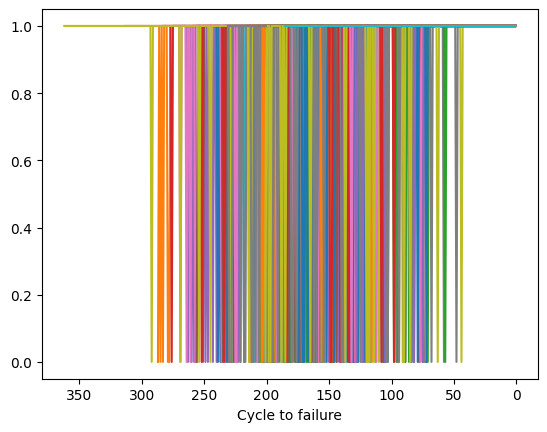

In [28]:
plot_feature(df_drop, 'p17')

In [29]:
df_drop

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2,cycle_to_fail,fail_next_30
0,1,1,47.47,521.66,2388.02,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,1.0,554.36,2388.06,-0.0007,-0.0004,192,0
1,1,2,47.49,522.28,2388.07,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,1.0,553.75,2388.04,0.0019,-0.0003,191,0
2,1,3,47.27,522.42,2388.03,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,1.0,554.26,2388.08,-0.0043,0.0003,190,0
3,1,4,47.13,522.86,2388.08,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,1.0,554.45,2388.11,0.0007,0.0000,189,0
4,1,5,47.28,522.19,2388.04,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,1.0,554.00,2388.06,-0.0019,-0.0002,188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,1.0,552.24,2388.20,0.0042,0.0002,5,1
16134,80,182,48.41,520.06,2388.12,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,1.0,551.60,2388.16,-0.0014,0.0004,4,1
16135,80,183,48.04,519.67,2388.21,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,1.0,551.78,2388.12,0.0018,0.0000,3,1
16136,80,184,48.04,519.72,2388.20,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,1.0,551.78,2388.17,-0.0024,0.0002,2,1


Split to train and test

In [30]:
np.random.seed(SEED)
random_idx = np.random.permutation(np.arange(1, df.id.max() + 1))
train_idx = random_idx[:int(df.id.max() * TRAIN_SPLIT_SIZE)]
test_idx = random_idx[int(df.id.max() * TRAIN_SPLIT_SIZE):]

df_train = df_drop[df_drop['id'].isin(train_idx)]
df_test = df_drop[df_drop['id'].isin(test_idx)]

In [31]:
# train timeseries id
np.sort(train_idx)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
       23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 62, 63,
       65, 66, 67, 68, 69, 71, 73, 74, 76, 77, 78, 79, 80], dtype=int64)

In [32]:
# test timeseries id
np.sort(test_idx)

array([ 2,  3, 15, 21, 22, 24, 30, 38, 52, 53, 60, 61, 64, 70, 72, 75],
      dtype=int64)

## Baseline model

#### Regression task

In [33]:
X_regr_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_train = df_train['cycle_to_fail']
X_regr_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_test = df_test['cycle_to_fail']

In [34]:
# Normalize dataset
std_scaler = StandardScaler()
std_scaler.fit_transform(X_regr_train)
X_train_scaled = std_scaler.transform(X_regr_train)
X_test_scaled = std_scaler.transform(X_regr_test)

In [35]:
lr_regr = LinearRegression().fit(X_train_scaled, y_regr_train)
lr_regr.score(X_test_scaled, y_regr_test)

0.6945285962318488

In [36]:
lr_pred = lr_regr.predict(X_test_scaled)

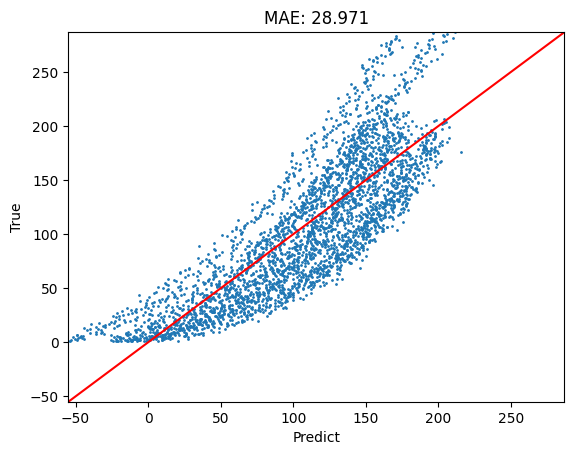

In [37]:
crossplot_pred(lr_pred, y_regr_test)

In [38]:
X_regr_test['predict'] = lr_pred
X_regr_test['id'] = df_test['id']  # return removed feature

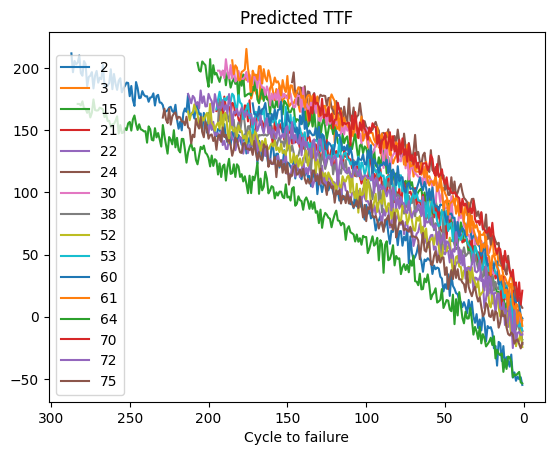

In [39]:
plot_feature(X_regr_test, 'predict', show_legend=True, title='Predicted TTF')

calculate mean predicted TTF at last 30 cycle of timeseries

In [40]:
X_regr_test['id'] = df_test['id']
X_regr_test['target'] = y_regr_test
X_regr_test[X_regr_test['target'] <= 30].groupby(by='id').mean()['predict'].sort_values()

id
64   -30.803394
2    -26.580905
75    -3.837508
52     4.746790
22     9.002935
72    10.655057
15    18.815139
38    20.122270
53    24.654758
21    26.050138
30    29.307459
60    31.751299
61    32.550430
3     40.174080
24    49.772130
70    51.053183
Name: predict, dtype: float64

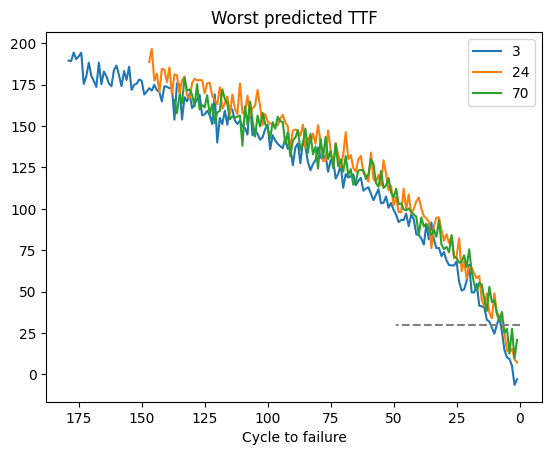

In [41]:
plot_feature(X_regr_test, 'predict', timeseries=[3, 24, 70], show_legend=True, title='Worst predicted TTF')
plt.plot(np.arange(50), np.full(50, 30), color='gray', ls='--')

In [42]:
X_regr_test[X_regr_test.id == 70]['predict'][-30:]

14100    75.569814
14101    77.035966
14102    73.761294
14103    84.097588
14104    71.347935
14105    70.278660
14106    67.516085
14107    67.907345
14108    71.907019
14109    64.716317
14110    75.516490
14111    62.172254
14112    54.450633
14113    50.558968
14114    55.336612
14115    54.242068
14116    45.547345
14117    38.338572
14118    52.904957
14119    43.697141
14120    44.684460
14121    36.533967
14122    32.251797
14123    37.708867
14124    25.098920
14125    27.549278
14126    12.626232
14127    27.555089
14128     9.794836
14129    20.888981
Name: predict, dtype: float64

The worst result of linear regression for timeseries 70 is to show TTF less than 30 before real failure in only 6 cycles.

### Classification task

In [43]:
X_cls_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_cls_train = df_train['fail_next_30']
X_cls_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_cls_test = df_test['fail_next_30']

In [44]:
df_train

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2,cycle_to_fail,fail_next_30
0,1,1,47.47,521.66,2388.02,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,1.0,554.36,2388.06,-0.0007,-0.0004,192,0
1,1,2,47.49,522.28,2388.07,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,1.0,553.75,2388.04,0.0019,-0.0003,191,0
2,1,3,47.27,522.42,2388.03,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,1.0,554.26,2388.08,-0.0043,0.0003,190,0
3,1,4,47.13,522.86,2388.08,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,1.0,554.45,2388.11,0.0007,0.0000,189,0
4,1,5,47.28,522.19,2388.04,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,1.0,554.00,2388.06,-0.0019,-0.0002,188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,1.0,552.24,2388.20,0.0042,0.0002,5,1
16134,80,182,48.41,520.06,2388.12,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,1.0,551.60,2388.16,-0.0014,0.0004,4,1
16135,80,183,48.04,519.67,2388.21,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,1.0,551.78,2388.12,0.0018,0.0000,3,1
16136,80,184,48.04,519.72,2388.20,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,1.0,551.78,2388.17,-0.0024,0.0002,2,1


In [45]:
# Normalize dataset
std_scaler = StandardScaler()
std_scaler.fit_transform(X_cls_test)
X_train_scaled = std_scaler.transform(X_cls_train)
X_test_scaled = std_scaler.transform(X_cls_test)

In [46]:
cls_regr = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_cls_train)
cls_regr.score(X_test_scaled, y_cls_test)

0.9514232673267327

In [47]:
cls_pred = cls_regr.predict(X_test_scaled)
cls_pred_proba = cls_regr.predict_proba(X_test_scaled)

In [48]:
conf_matrix = metrics.confusion_matrix(y_cls_test, cls_pred)
true_negative = conf_matrix[0, 0]
true_positive = conf_matrix[1, 1]
false_negative = conf_matrix[0, 1]
false_positive = conf_matrix[1, 0]

In [49]:
recall = true_positive / (false_negative + true_positive)
precision = true_positive / (false_positive + true_positive)
print(f"Recall is {recall:.3f}, Precision is {precision:.3f}")

Recall is 0.858, Precision is 0.806


Plot predicted probability.

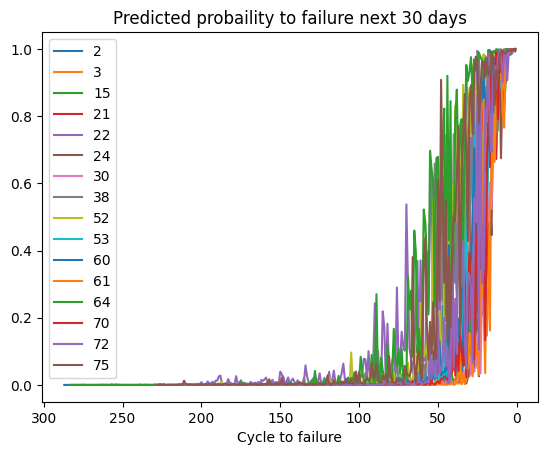

In [50]:
X_cls_test['predict'] = cls_pred_proba[:, 1]
X_cls_test['id'] = df_test['id']  # return removed feature
plot_feature(X_cls_test, 'predict', show_legend=True, title='Predicted probaility to failure next 30 days')

calculate mean predicted probabity at last 30 cycle of timeseries

In [51]:
X_cls_test['target'] = y_cls_test
X_cls_test[X_cls_test['target'] == 1].groupby(by='id').mean()['predict'].sort_values()

id
61    0.588603
30    0.593058
24    0.594743
3     0.595562
15    0.682124
70    0.713076
21    0.735649
72    0.759026
53    0.766483
60    0.833386
38    0.871838
2     0.884528
22    0.913315
52    0.934500
75    0.940550
64    0.976073
Name: predict, dtype: float64

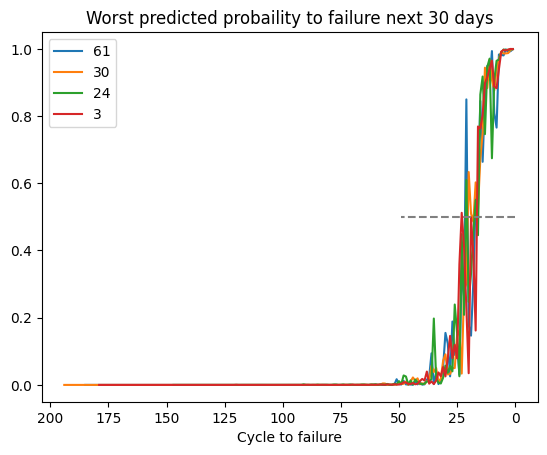

In [52]:
plot_feature(X_cls_test, 'predict', timeseries=[61, 30, 24, 3], show_legend=True, title='Worst predicted probaility to failure next 30 days')
plt.plot(np.arange(50), np.full(50, .5), color='gray', ls='--')

In [53]:
X_cls_test[X_cls_test.id == 24]['predict'][-30:]

4850    0.057515
4851    0.035986
4852    0.057240
4853    0.040312
4854    0.239264
4855    0.155096
4856    0.025700
4857    0.448759
4858    0.208637
4859    0.609577
4860    0.246976
4861    0.331291
4862    0.452454
4863    0.550171
4864    0.445464
4865    0.864129
4866    0.917679
4867    0.746245
4868    0.946460
4869    0.970847
4870    0.674443
4871    0.906668
4872    0.964508
4873    0.967878
4874    0.989383
4875    0.997921
4876    0.996890
4877    0.996640
4878    0.998793
4879    0.999367
Name: predict, dtype: float64

The worst result of linear regression for timeseries 24 is to show TTF less than 30 before real failure in only 15 cycles.

#### Baseline conclusion
##### Regression task
- linear regression has TTF MAE value is 29.
- 3 out of 16 engine test series drop predicted TTF less than 30 cycle when real TTF is 7 cycles.
- this will cause the engine to fail until it is stopped for repairs.
##### Classification task
- precision is 0.806.
- 4 out of 16 engine test series predict failure in next 30 cycle when real TTF is 15 cycles. It's better then linear regression.
- logistic regression have nervous cycle-to-cycle predicted probabity. Operator of ML system will not trust this prediction and could be ignore it.

## Transformers

Ideas: 
- Use the transformers architecture to solve classification and regression problem.
- Pass engine parameters for the last 30 cycles to the model and predict TTF and failure within 30 days.
- Add unsymmetrical losses to prevent predicting less than the real life cycle.

In [54]:
# normalize data
X_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
X_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_train = df_train['cycle_to_fail']
y_cls_train = df_train['fail_next_30']

X_regr_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
X_cls_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_test = df_test['cycle_to_fail']
y_cls_test = df_test['fail_next_30']

std_scaler = StandardScaler()
std_scaler.fit_transform(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

#### Regression task

In [55]:
# create dataloader
train_dataloader = create_dataloader(df_train, X_train_scaled, y_regr_train, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
test_dataloader = create_dataloader(df_test, X_test_scaled, y_regr_test, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE, shuffle=False, drop_last=False)

In [56]:
model = TimeSeriesTransformer(d_model=16, nhead=4, num_encoder_layers=4, dim_feedforward=64, dropout=0.4, window_size=WINDOW_SIZE)

In [57]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR / 10, weight_decay=WEIGHT_DECAY)
criterion = AsymmetricMSELoss(scale=2.)

In [58]:
train(model, N_EPOCHS, train_dataloader, optimizer, criterion, test_dataloader=test_dataloader)

epoch: 1/60, train_loss: 10709.556,test_loss: 8041.429, Time: 2.049
epoch: 2/60, train_loss: 7184.714,test_loss: 5298.559, Time: 0.523
epoch: 3/60, train_loss: 4915.822,test_loss: 3627.969, Time: 0.522
epoch: 4/60, train_loss: 3572.333,test_loss: 2866.576, Time: 0.516
epoch: 5/60, train_loss: 2818.289,test_loss: 2550.127, Time: 0.629
epoch: 6/60, train_loss: 2435.561,test_loss: 2332.244, Time: 0.527
epoch: 7/60, train_loss: 2284.250,test_loss: 2631.995, Time: 0.529
epoch: 8/60, train_loss: 2200.834,test_loss: 2869.252, Time: 0.533
epoch: 9/60, train_loss: 2261.143,test_loss: 2189.549, Time: 0.516
epoch: 10/60, train_loss: 2285.028,test_loss: 2321.856, Time: 0.522
epoch: 11/60, train_loss: 2224.376,test_loss: 2169.338, Time: 0.529
epoch: 12/60, train_loss: 1899.201,test_loss: 2272.482, Time: 0.516
epoch: 13/60, train_loss: 1868.278,test_loss: 2223.489, Time: 0.523
epoch: 14/60, train_loss: 1927.532,test_loss: 2289.750, Time: 0.532
epoch: 15/60, train_loss: 1784.536,test_loss: 2352.376, 

In [59]:
predicted, idx = predict(model, test_dataloader, batch_size=BATCH_SIZE)

In [60]:
pred_ = np.full(y_regr_test.shape[0], np.nan)
for i, pred in zip(idx, predicted):
    pred_[i + WINDOW_SIZE - 1] = pred

In [61]:
X_regr_test['predict'] = pred_
X_regr_test['id'] = df_test['id']  # return removed feature

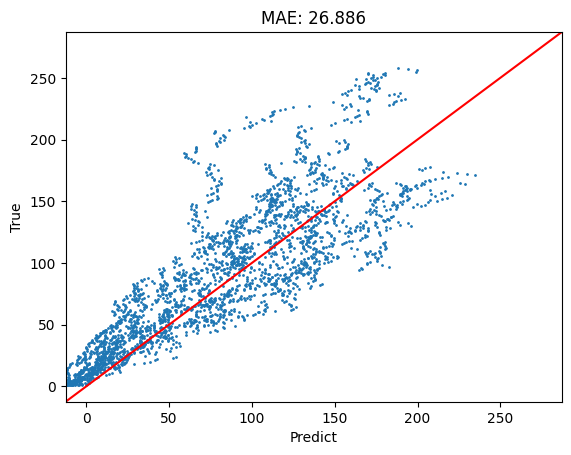

In [62]:
crossplot_pred(pred_, y_regr_test)

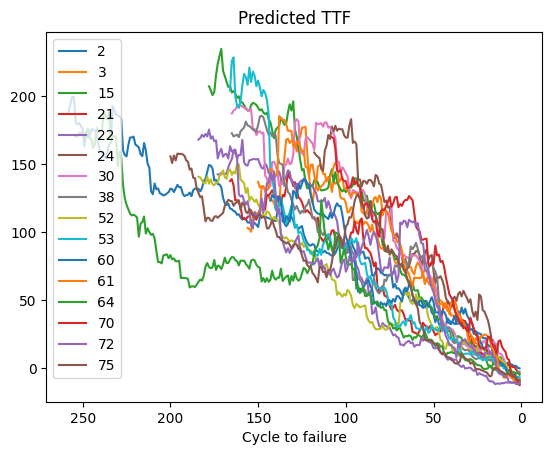

In [63]:
plot_feature(X_regr_test, 'predict', show_legend=True, title='Predicted TTF')

Calculate TTF at last 30 cycles

In [64]:
X_regr_test['id'] = df_test['id']
X_regr_test['target'] = y_regr_test
X_regr_test[X_regr_test['target'] <= 30].groupby(by='id').mean()['predict'].sort_values()

id
22    -7.975500
75    -2.560843
64    -0.613407
72     2.468286
53     3.412132
38     3.710630
15     4.117922
3      4.662242
52     6.359404
61     8.226460
21     8.323293
30     8.829537
60     9.454581
2     13.394312
70    13.502765
24    19.583482
Name: predict, dtype: float64

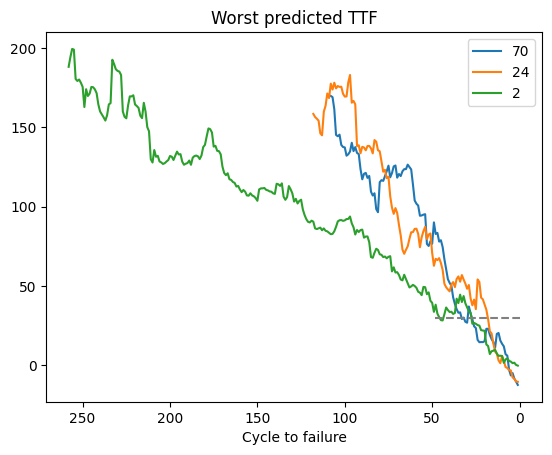

In [65]:
plot_feature(X_regr_test, 'predict', timeseries=[70, 24, 2], show_legend=True, title='Worst predicted TTF')
plt.plot(np.arange(50), np.full(50, 30), color='gray', ls='--')

In [80]:
X_regr_test[X_regr_test.id == 24]['predict'][-30:]

4850    48.261887
4851    50.613258
4852    42.142948
4853    37.835602
4854    41.415466
4855    35.415043
4856    54.129543
4857    52.551605
4858    42.643780
4859    41.596539
4860    38.354042
4861    35.034752
4862    29.144876
4863    21.423597
4864    20.077326
4865    13.949544
4866     8.619572
4867     7.289594
4868     3.015703
4869     1.295992
4870     5.834440
4871     2.819688
4872    -1.130868
4873    -1.707465
4874    -3.116755
4875    -3.208447
4876    -7.635560
4877    -8.560763
4878   -10.172013
4879   -10.428452
Name: predict, dtype: float64

#### classification task

In [83]:
# create dataloader
train_dataloader = create_dataloader(df_train, X_train_scaled, y_cls_train, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
test_dataloader = create_dataloader(df_test, X_test_scaled, y_cls_test, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE, shuffle=False, drop_last=False)

In [84]:
model = TimeSeriesTransformer(d_model=16, nhead=4, num_encoder_layers=6, dim_feedforward=64, dropout=0.4, window_size=WINDOW_SIZE, add_sigmoid=True)

In [85]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR / 10, weight_decay=WEIGHT_DECAY)
criterion = AsymmetricBCELoss(scale=5.)

In [86]:
train(model, N_EPOCHS // 3, train_dataloader, optimizer, criterion, test_dataloader=test_dataloader)

epoch: 1/20, train_loss: 0.479,test_loss: 0.386, Time: 0.740
epoch: 2/20, train_loss: 0.352,test_loss: 0.338, Time: 0.609
epoch: 3/20, train_loss: 0.288,test_loss: 0.277, Time: 0.605
epoch: 4/20, train_loss: 0.230,test_loss: 0.213, Time: 0.609
epoch: 5/20, train_loss: 0.186,test_loss: 0.182, Time: 0.608
epoch: 6/20, train_loss: 0.158,test_loss: 0.156, Time: 0.611
epoch: 7/20, train_loss: 0.151,test_loss: 0.229, Time: 0.606
epoch: 8/20, train_loss: 0.134,test_loss: 0.146, Time: 0.631
epoch: 9/20, train_loss: 0.124,test_loss: 0.154, Time: 0.605
epoch: 10/20, train_loss: 0.114,test_loss: 0.132, Time: 0.603
epoch: 11/20, train_loss: 0.105,test_loss: 0.146, Time: 0.603
epoch: 12/20, train_loss: 0.101,test_loss: 0.132, Time: 0.605
epoch: 13/20, train_loss: 0.096,test_loss: 0.152, Time: 0.604
epoch: 14/20, train_loss: 0.090,test_loss: 0.141, Time: 0.605
epoch: 15/20, train_loss: 0.087,test_loss: 0.169, Time: 0.606
epoch: 16/20, train_loss: 0.083,test_loss: 0.140, Time: 0.612
epoch: 17/20, tra

In [87]:
predicted, idx = predict(model, test_dataloader, batch_size=BATCH_SIZE)

In [88]:
cls_pred = np.full(y_cls_test.shape[0], np.nan)
for i, pred in zip(idx, predicted):
    cls_pred[i + WINDOW_SIZE - 1] = pred

In [89]:
y_test = pd.DataFrame(y_cls_test)
y_test['predict_proba'] = cls_pred
y_test['predict'] = y_test['predict_proba'] > .5
y_test.dropna(inplace=True)

In [90]:
conf_matrix = metrics.confusion_matrix(y_test['fail_next_30'], y_test['predict'])
true_negative = conf_matrix[0, 0]
true_positive = conf_matrix[1, 1]
false_negative = conf_matrix[0, 1]
false_positive = conf_matrix[1, 0]

In [91]:
recall = true_positive / (false_negative + true_positive)
precision = true_positive / (false_positive + true_positive)
print(f"Recall is {recall:.3f}, Precision is {precision:.3f}")

Recall is 0.840, Precision is 0.973


Plot predicted probability.

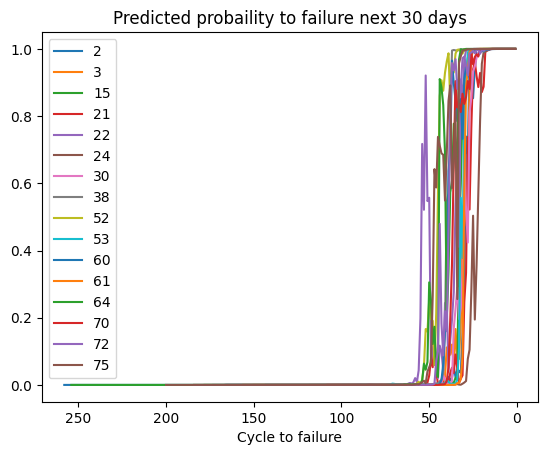

In [92]:
X_cls_test['predict'] = y_test['predict_proba']
X_cls_test['id'] = df_test['id']  # return removed feature
plot_feature(X_cls_test, 'predict', show_legend=True, title='Predicted probaility to failure next 30 days')

calculate mean predicted probabity at last 30 cycle of timeseries

In [93]:
X_cls_test['target'] = y_test['fail_next_30']
X_cls_test[X_cls_test['target'] == 1].groupby(by='id').mean()['predict'].sort_values()

id
24    0.760688
21    0.899517
30    0.937716
3     0.944731
2     0.944985
70    0.978421
61    0.979890
60    0.989803
53    0.989902
72    0.992472
15    0.992646
22    0.998453
75    0.999554
52    0.999615
64    0.999924
38    0.999967
Name: predict, dtype: float64

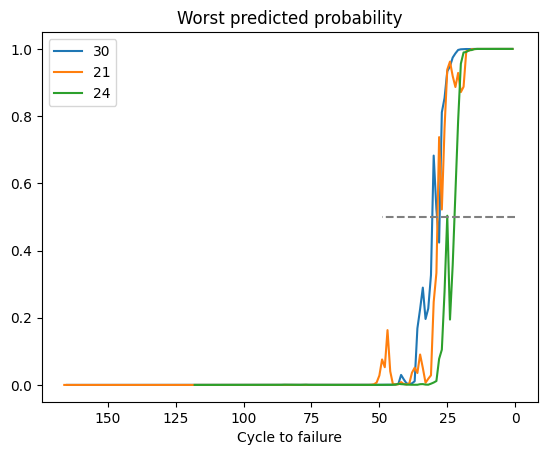

In [94]:
plot_feature(X_cls_test, 'predict', timeseries=[30, 21, 24], show_legend=True, title='Worst predicted probability')
plt.plot(np.arange(50), np.full(50, .5), color='gray', ls='--')

In [95]:
X_cls_test[X_cls_test.id == 24]['predict'][-30:]

4850    0.007098
4851    0.011635
4852    0.077586
4853    0.104881
4854    0.277464
4855    0.503593
4856    0.194544
4857    0.356811
4858    0.572323
4859    0.786378
4860    0.955874
4861    0.989466
4862    0.990901
4863    0.996276
4864    0.996614
4865    0.999442
4866    0.999901
4867    0.999946
4868    0.999987
4869    0.999982
4870    0.999981
4871    0.999988
4872    0.999993
4873    0.999994
4874    0.999994
4875    0.999995
4876    0.999997
4877    0.999996
4878    0.999993
4879    0.999995
Name: predict, dtype: float64

#### Transformers conclusion
Overall: Transformers tend to overfit on the train dataset. This is corrected by a large `weight_decay` value and a `dropout_rate`.
##### Regression task
- Transformer has TTF MAE value is 26.5. It's better than base model. Also asymmetric losses raise the symmetric metrics.
- the worst of 16 engine test series drop predicted TTF less than 30 cycle when real TTF is 20 cycles. It's twice better that base model.
- 10 out of 16 engine test series predicted TTF much less than real. It could be fixed by research of scale factor
##### Classification task
- precision is 0.979. It's much better than base model. Choose scale factor for asymmetric loss could improve precision by reducing recall.
- the worst of 16 engine test series predict failure in next 30 cycle when real TTF is 22 cycles. It's almost better that base model.

## Conclusions

1. Makes the EDA of present dataset and clear it.
2. Put forward the business hypothesis and formulate it as an ML problem.
3. Fit the baseline models and find weak places of fitted models.
4. Weak places fixed with transformer models and asymmetric losses.
5. Classification task give the safer predictions.